## Get a dataset to work with

In [10]:
# fetch the images for the dataset
# this will take a long time the first run because it needs to download
# after the first time, the dataset will be save to your disk (in sklearn package somewhere) 
# if this does not run, you may need additional libraries installed on your system (you will need to figure out which ones!!)
from sklearn.datasets import fetch_lfw_people

# only load people that have N or more examples in the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4) 

Size of the dataset: (2489, 1850)
Number of unique classes: 43
['George Robertson' 'George W Bush' 'Gerhard Schroeder'
 'Gloria Macapagal Arroyo' 'Gray Davis' 'Hamid Karzai' 'Hans Blix'
 'Hugo Chavez' 'Igor Ivanov' 'Jack Straw']


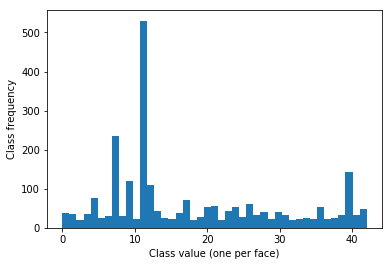

In [11]:
print ('Size of the dataset:', lfw_people.data.shape)
print ('Number of unique classes:', len(lfw_people.target_names))
print (lfw_people.target_names[10:20])

from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(lfw_people.target, bins=len(lfw_people.target_names))
plt.xlabel('Class value (one per face)')
plt.ylabel('Class frequency')
plt.show()

## Set up data, X, Y, scale, and cv splits

In [133]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn import metrics as mt

# create variables we are more familiar with
X = lfw_people.data
y = lfw_people.target
yhat = np.zeros(y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

## Create model using GaussianNB and test for accuracy 

In [134]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=100,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

yhat_score = np.zeros((y.shape[0],len(lfw_people.target_names)))

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('Pipeline accuracy', total_accuracy)

Pipeline accuracy 0.5893933306548815


## Understanding what the outputs for Predicted Probabilities look like
* Below we show the values for the variable yhat_score after it is populated by predict_proba()
* The shape tells us that we have one set of predicted probabilities for each of the 2489 records in the test data X[test]
* Since there are 43 classes, we have one predicted probability for each class. 

In [185]:
yhat_score.shape

(2489, 43)

**We will also look at the actual and predicted counts for class 0**

In [202]:
pd.value_counts(y == 0)

False    2450
True       39
dtype: int64

In [203]:
pd.value_counts(yhat == 0)

False    2462
True       27
dtype: int64

### The confusion matrix shows us how we did on predicting the 39 class 0 records
* We have 18 correctly predicted as class 0
* and 21 incorrectly predicted as other classes

In [209]:
np.set_printoptions(threshold=np.inf,suppress=False,precision=8)
cm = mt.confusion_matrix(y, yhat,np.unique(y))
cm[:][0]

array([18,  0,  0,  2,  1,  0,  0,  4,  0,  0,  0,  5,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  1], dtype=int64)

In [262]:
sum(cm[:][0])

39

**The predicted probabilities for the first test record are displayed below**  

In [210]:
print(yhat_score[:][0])

[4.14022125e-04 3.50954212e-08 4.58731368e-09 5.96899793e-10
 9.76219007e-06 1.95894631e-11 7.81204618e-05 2.25781894e-02
 4.43084575e-08 4.70380837e-05 1.91393724e-12 9.71686810e-01
 1.07635460e-03 1.76567733e-11 1.01539536e-06 4.02664967e-07
 1.59189551e-05 7.54370232e-07 2.21534217e-09 3.35115382e-08
 1.11447672e-04 7.89152076e-06 4.31181008e-04 1.21900861e-05
 6.93135902e-06 1.12629763e-08 3.54185491e-06 2.49214186e-07
 4.01391468e-09 1.76742108e-08 1.04887327e-05 6.96197946e-10
 9.35002460e-06 1.40400089e-09 7.81136311e-09 1.58290355e-09
 2.77624243e-09 2.52861057e-07 4.42354204e-06 2.06643398e-08
 7.89533810e-04 1.26251750e-10 2.70394142e-03]


**The the highest predicted probabilty for the first test record is 96.9%**

In [211]:
print(max(yhat_score[:][0]))

0.9716868102986519


**The class with the highest predicted proability is class index 11 / class number 10** 

In [212]:
yhat_score[:][0,11]

0.9716868102986519

## Using the ROC Curve
In the below example we can see how to graph the false negatives and false positives in an ROC curve for a given classifier. Please note that the "scores" from the classifier have already been populated using the code above. The scores can be interpretted as the the probability that a given class should be designated as positive. These scores are needed so that the ROC can change thresholds deciding if theclass is positive or negative. Once we have the scores, we can send each column of scores (i.e., the probability for that class being positive) into the ROC curve generator and it will give use the arrays of false positives and negatives for that class as the threshold is increased. 

We save the outputs into a dictionary of fpr and tpr (false positive and true positive rates). The keys to the dictionary are the class value. We can also compute the ROC treshold for all the classes by placing their probabilities into one giant vector and whether they should or should not be a value of one. Please note that this method of combining all classes into a single ROC is not considered a standard method--it has limited utility outside classifier comparison. If you understand the limitations it can be an effective tool. If not, then I would not recommend using it to compare models right away. 

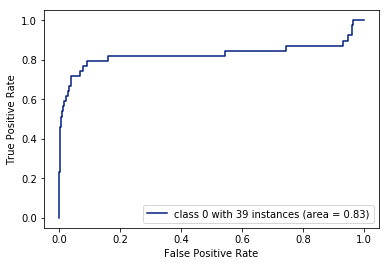

In [167]:
import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
thresh = dict()
for i in np.unique(y):
    fpr[i], tpr[i], thresh[i] = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], label='class {0} with {1} instances (area = {2:0.2f})'
''.format(0, sum(y==0), roc_auc[0]))

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## What goes into the ROC curve as Input?
* Below we are specifically looking at the inputs for the above code: **mt.roc_curve(y, yhat_score[:, i], pos_label=i)**
* The code above uses 2498 test records to calculate the ROC curve for all 43 classes
* We are plotting the ROC curve for one class (class 0) above
* There were only 39 out of 2489 test records which belong to class 0
* The area under the curve for class 0 is 0.83 

### y contains the class lables
* Note there are 2489 correct responses for y
* Each response is just the actual class number that a given test record belongs to.

In [213]:
#np.set_printoptions(threshold=np.inf)
print(len(y))

2489


In [214]:
np.set_printoptions(threshold=1000)
print(y)

[11  7 11 ... 11 12 11]


### yhat_score contains the predicted probabilities
* Note that we have 2489 test records.
* There are 43 predicted probabilities for each of the 2489 test records. 
* There are only 39 test records with a class label == 0.

In [215]:
print(len(yhat_score))

2489


In [216]:
print(len(yhat_score[:][0]))

43


In [217]:
sum(y==0)

39

### However, we only use part of yhat_score to calculate a single ROC curve for a single class.
* For each ROC curve calculated, we only pass in a single column of data from yhat_score
* For class 0, the roc_curve() function isolates the class 0 records using pos_label=0
* The roc_curve() function then calculates the false and true positive rates at 56 different thresholds.
* The area under the curve is 82.88% mt.auc()

In [218]:
yhat_score[:, 0].shape

(2489,)

In [219]:
print(len(fpr[0]))

56


In [220]:
print(len(tpr[0]))

56


In [221]:
print(len(thresh[0]))

56


In [224]:
mt.auc(fpr[0], tpr[0])

0.8288016745159602

## Micro Average ROC Curve Inputs Example

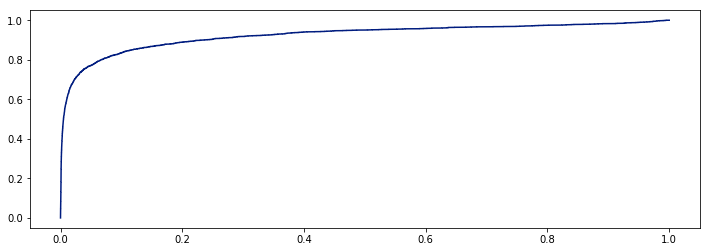

In [247]:
# combined ROC over all classes
one_hot_class_encoding = label_binarize(y,np.unique(y))
fpr["micro"], tpr["micro"], thresh["micro"] = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,4))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

## What goes into the Micro Average ROC curve as Input?
* Below we are specifically looking at the inputs for the above code: **mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())**
* The variable one_hot_class_encoding is created using the label_binarize(y,np.unique(y)) function
* label_binarize() creates a one hot encoded matrix using 2489 test lables from y and 43 unique classes (np.unique(y))
* This results in a 2489 x 43 matrix that contains 107,027 intersections / values
* The ravel function converts the matrix into an array with 107,027 values  

In [249]:
one_hot_class_encoding.shape

(2489, 43)

In [250]:
2489 * 43

107027

In [254]:
len(one_hot_class_encoding.ravel())

107027

* yhat_score is also a 2489 x 43 matrix full of predicted probabilities
* The ravel function converts the matrix into an array with 107,027 values  

In [261]:
yhat_score.shape

(2489, 43)

In [255]:
len(yhat_score.ravel())

107027

* The roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel()) function takes both of the 107,027 value arrays as input.
* It returns true and false positive rates for 2858 thresholds used to plot the micro average roc curve. 

In [259]:
print(len(tpr['micro']))

2858


In [260]:
print(len(fpr['micro']))

2858


In [256]:
print(len(thresh['micro']))

2858


## For Details on how ROC curves are calculated see:
* https://stats.stackexchange.com/questions/145566/how-to-calculate-area-under-the-curve-auc-or-the-c-statistic-by-hand
* https://stackoverflow.com/questions/50848163/manually-calculate-auc
* https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/_ranking.py